In [ ]:

# Load necessary libraries and examine the datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Load the two design datasets
hybrid_df = pd.read_csv('hybrid_designs.csv')
hybrid2_df = pd.read_csv('hybrid_2.0_designs.csv')

# Examine the structure of both datasets
print("Hybrid Designs Dataset:")
print(f"Shape: {hybrid_df.shape}")
print(f"\nColumns: {hybrid_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(hybrid_df.head())
print("\n" + "="*80 + "\n")

print("Hybrid 2.0 Designs Dataset:")
print(f"Shape: {hybrid2_df.shape}")
print(f"\nColumns: {hybrid2_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(hybrid2_df.head())


Hybrid Designs Dataset:
Shape: (15750, 13)

Columns: ['Scaffold', 'Loop_Position', 'Loop_Range', 'Parent_Antibody', 'Parent_CDR', 'Parent_Subsequence', 'Mutation', 'Hybrid_Sequence', 'Hybrid_Length', 'Design_Sequence', 'Epitope_Type', 'Motif_MJ_Score', 'Normalized_MJ_Score']

First few rows:
  Scaffold  Loop_Position Loop_Range Parent_Antibody Parent_CDR  \
0     1FNA              1      25-33             1E5         H3   
1     1FNA              2      40-48             1E5         H3   
2     1FNA              3      60-68             1E5         H3   
3     1TEN              1      15-23             1E5         H3   
4     1TEN              2      40-48             1E5         H3   

  Parent_Subsequence Mutation Hybrid_Sequence  Hybrid_Length  \
0           ARDYQYYY      A1S        SRDYQYYY              8   
1           ARDYQYYY      A1S        SRDYQYYY              8   
2           ARDYQYYY      A1S        SRDYQYYY              8   
3           ARDYQYYY      A1S        SRDYQYYY   

In [ ]:

# Step 1: Extract 9-mer motifs from both datasets
# For hybrid_designs.csv, we need to check the Hybrid_Sequence column
# For hybrid_2.0_designs.csv, we need to check the Double_Mutant_Sequence column

# First, let's examine the motif lengths in both datasets
print("Hybrid Designs - Hybrid_Length distribution:")
print(hybrid_df['Hybrid_Length'].value_counts().sort_index())
print("\n" + "="*80 + "\n")

print("Hybrid 2.0 Designs - Motif_Length distribution:")
print(hybrid2_df['Motif_Length'].value_counts().sort_index())
print("\n" + "="*80 + "\n")

# Filter for 9-mer motifs from both datasets
hybrid_9mers = hybrid_df[hybrid_df['Hybrid_Length'] == 9].copy()
hybrid2_9mers = hybrid2_df[hybrid2_df['Motif_Length'] == 9].copy()

print(f"Number of 9-mer designs in hybrid_designs.csv: {len(hybrid_9mers)}")
print(f"Number of 9-mer designs in hybrid_2.0_designs.csv: {len(hybrid2_9mers)}")

# Extract the motif sequences
hybrid_9mers['Motif'] = hybrid_9mers['Hybrid_Sequence']
hybrid2_9mers['Motif'] = hybrid2_9mers['Double_Mutant_Sequence']

print(f"\nUnique 9-mer motifs in hybrid_designs: {hybrid_9mers['Motif'].nunique()}")
print(f"Unique 9-mer motifs in hybrid_2.0_designs: {hybrid2_9mers['Motif'].nunique()}")


Hybrid Designs - Hybrid_Length distribution:
Hybrid_Length
8    8217
9    7533
Name: count, dtype: int64


Hybrid 2.0 Designs - Motif_Length distribution:
Motif_Length
9    44343
Name: count, dtype: int64


Number of 9-mer designs in hybrid_designs.csv: 7533
Number of 9-mer designs in hybrid_2.0_designs.csv: 44343

Unique 9-mer motifs in hybrid_designs: 837
Unique 9-mer motifs in hybrid_2.0_designs: 4927


In [ ]:

# Step 2: Calculate Residual Scores for each design
# According to the documentation, we need to fit strategy-specific polynomial regression models
# First, let's identify the epitope type (competitive vs allosteric) for both datasets

print("Hybrid Designs - Epitope_Type distribution:")
print(hybrid_df['Epitope_Type'].value_counts())
print("\n" + "="*80 + "\n")

# Check if hybrid_2.0_designs has epitope type information
if 'Epitope_Type' in hybrid2_df.columns:
    print("Hybrid 2.0 Designs - Epitope_Type distribution:")
    print(hybrid2_df['Epitope_Type'].value_counts())
else:
    print("Hybrid 2.0 Designs does not have Epitope_Type column")
    print("Checking parent information to infer epitope type...")
    
# Since we're focusing on allosteric motifs, let's filter for allosteric designs
print("\nExamining Motif_MJ_Score ranges:")
print(f"Hybrid designs - Motif_MJ_Score range: {hybrid_df['Motif_MJ_Score'].min():.2f} to {hybrid_df['Motif_MJ_Score'].max():.2f}")
print(f"Hybrid 2.0 designs - Motif_MJ_Score range: {hybrid2_df['Motif_MJ_Score'].min():.2f} to {hybrid2_df['Motif_MJ_Score'].max():.2f}")


Hybrid Designs - Epitope_Type distribution:
Epitope_Type
competitive    8334
allosteric     7416
Name: count, dtype: int64


Hybrid 2.0 Designs does not have Epitope_Type column
Checking parent information to infer epitope type...

Examining Motif_MJ_Score ranges:
Hybrid designs - Motif_MJ_Score range: -19.00 to -7.51
Hybrid 2.0 designs - Motif_MJ_Score range: -130.06 to -61.27


In [ ]:

# The research objective specifies allosteric motifs
# From hybrid_designs, we can filter for Epitope_Type == 'allosteric'
# For hybrid_2.0_designs, we need to check if it was derived from allosteric designs

# Let's check the parent subsequences in hybrid_2.0 to see if they match allosteric parents from hybrid_designs
allosteric_hybrid_df = hybrid_df[hybrid_df['Epitope_Type'] == 'allosteric'].copy()

print(f"Allosteric designs in hybrid_designs.csv: {len(allosteric_hybrid_df)}")
print(f"Allosteric 9-mer designs in hybrid_designs.csv: {len(allosteric_hybrid_df[allosteric_hybrid_df['Hybrid_Length'] == 9])}")

# Check parent subsequences from hybrid_2.0 against allosteric hybrid parents
allosteric_parents = set(allosteric_hybrid_df['Hybrid_Sequence'].unique())
hybrid2_parents = set(hybrid2_df['Parent_Subsequence'].unique())

# Check overlap
overlap = allosteric_parents.intersection(hybrid2_parents)
print(f"\nParent subsequences in hybrid_2.0 that match allosteric hybrid sequences: {len(overlap)}")
print(f"Total unique parent subsequences in hybrid_2.0: {len(hybrid2_parents)}")

# Check if all hybrid_2.0 parents are from allosteric designs
competitive_parents = set(hybrid_df[hybrid_df['Epitope_Type'] == 'competitive']['Hybrid_Sequence'].unique())
competitive_overlap = competitive_parents.intersection(hybrid2_parents)
print(f"Parent subsequences in hybrid_2.0 that match competitive hybrid sequences: {len(competitive_overlap)}")


Allosteric designs in hybrid_designs.csv: 7416
Allosteric 9-mer designs in hybrid_designs.csv: 3573

Parent subsequences in hybrid_2.0 that match allosteric hybrid sequences: 0
Total unique parent subsequences in hybrid_2.0: 25
Parent subsequences in hybrid_2.0 that match competitive hybrid sequences: 0


In [ ]:

# The parent subsequences in hybrid_2.0 don't directly match the Hybrid_Sequence from hybrid_designs
# This suggests hybrid_2.0 was built from the Parent_Subsequence column of hybrid_designs
# Let's check this

# Get all parent subsequences from allosteric hybrid designs
allosteric_parent_subseq = set(allosteric_hybrid_df['Parent_Subsequence'].unique())
hybrid2_parents = set(hybrid2_df['Parent_Subsequence'].unique())

overlap_parent = allosteric_parent_subseq.intersection(hybrid2_parents)
print(f"Parent_Subsequence overlap between allosteric hybrid and hybrid_2.0: {len(overlap_parent)}")
print(f"Total unique Parent_Subsequence in allosteric hybrid: {len(allosteric_parent_subseq)}")
print(f"Total unique Parent_Subsequence in hybrid_2.0: {len(hybrid2_parents)}")

# Check competitive overlap
competitive_parent_subseq = set(hybrid_df[hybrid_df['Epitope_Type'] == 'competitive']['Parent_Subsequence'].unique())
competitive_overlap_parent = competitive_parent_subseq.intersection(hybrid2_parents)
print(f"\nParent_Subsequence overlap between competitive hybrid and hybrid_2.0: {len(competitive_overlap_parent)}")

# Let's see what the parent subsequences in hybrid_2.0 are
print("\nSample of Parent_Subsequence in hybrid_2.0:")
print(hybrid2_df['Parent_Subsequence'].unique()[:10])


Parent_Subsequence overlap between allosteric hybrid and hybrid_2.0: 16
Total unique Parent_Subsequence in allosteric hybrid: 42
Total unique Parent_Subsequence in hybrid_2.0: 25

Parent_Subsequence overlap between competitive hybrid and hybrid_2.0: 9

Sample of Parent_Subsequence in hybrid_2.0:
['RASQGIIDY' 'GSISDTYRW' 'FCQQSKEVP' 'CQQSKEVPY' 'RASESVHDY' 'SESVHDYGI'
 'ESVHDYGIS' 'GGSISDTYR' 'QGIIDYLSW' 'YFCQQSKEV']


In [ ]:

# hybrid_2.0 contains both allosteric and competitive parent motifs
# Let's identify which hybrid_2.0 designs are allosteric by matching parent subsequences

# Create a mapping of parent subsequences to epitope type from hybrid_designs
parent_to_epitope = {}
for _, row in hybrid_df.iterrows():
    parent = row['Parent_Subsequence']
    epitope = row['Epitope_Type']
    if parent not in parent_to_epitope:
        parent_to_epitope[parent] = epitope
    elif parent_to_epitope[parent] != epitope:
        # If a parent subsequence appears in both epitope types, mark as "both"
        parent_to_epitope[parent] = 'both'

# Check which parents in hybrid_2.0 map to which epitope type
print("Epitope type mapping for hybrid_2.0 parent subsequences:")
epitope_counts = {'allosteric': 0, 'competitive': 0, 'both': 0, 'unknown': 0}
for parent in hybrid2_df['Parent_Subsequence'].unique():
    epitope_type = parent_to_epitope.get(parent, 'unknown')
    epitope_counts[epitope_type] += 1
    
print(epitope_counts)

# Add epitope type to hybrid_2.0 designs
hybrid2_df['Epitope_Type'] = hybrid2_df['Parent_Subsequence'].map(parent_to_epitope)
print(f"\nHybrid 2.0 designs by epitope type:")
print(hybrid2_df['Epitope_Type'].value_counts())

# Filter for allosteric 9-mers from hybrid_2.0
allosteric_hybrid2_9mers = hybrid2_df[hybrid2_df['Epitope_Type'] == 'allosteric'].copy()
print(f"\nAllosteric 9-mer designs in hybrid_2.0: {len(allosteric_hybrid2_9mers)}")
print(f"Unique allosteric 9-mer motifs in hybrid_2.0: {allosteric_hybrid2_9mers['Double_Mutant_Sequence'].nunique()}")


Epitope type mapping for hybrid_2.0 parent subsequences:
{'allosteric': 16, 'competitive': 9, 'both': 0, 'unknown': 0}

Hybrid 2.0 designs by epitope type:
Epitope_Type
allosteric     29052
competitive    15291
Name: count, dtype: int64

Allosteric 9-mer designs in hybrid_2.0: 29052
Unique allosteric 9-mer motifs in hybrid_2.0: 3228


In [ ]:

# Now combine allosteric 9-mers from both datasets
# First, get allosteric 9-mers from hybrid_designs
allosteric_hybrid_9mers = hybrid_9mers[hybrid_9mers['Epitope_Type'] == 'allosteric'].copy()

print(f"Allosteric 9-mers from hybrid_designs: {len(allosteric_hybrid_9mers)}")
print(f"Unique motifs: {allosteric_hybrid_9mers['Hybrid_Sequence'].nunique()}")

# Prepare combined dataset with standardized column names
allosteric_hybrid_9mers['Motif'] = allosteric_hybrid_9mers['Hybrid_Sequence']
allosteric_hybrid_9mers['Strategy'] = 'Hybrid'
allosteric_hybrid_9mers['Raw_MJ_Score'] = allosteric_hybrid_9mers['Motif_MJ_Score']

allosteric_hybrid2_9mers['Motif'] = allosteric_hybrid2_9mers['Double_Mutant_Sequence']
allosteric_hybrid2_9mers['Strategy'] = 'Hybrid_2.0'
allosteric_hybrid2_9mers['Raw_MJ_Score'] = allosteric_hybrid2_9mers['Motif_MJ_Score']

# Combine the datasets
combined_9mers = pd.concat([
    allosteric_hybrid_9mers[['Motif', 'Strategy', 'Raw_MJ_Score', 'Scaffold', 'Loop_Position']],
    allosteric_hybrid2_9mers[['Motif', 'Strategy', 'Raw_MJ_Score', 'Scaffold', 'Loop_Position']]
], ignore_index=True)

print(f"\nTotal allosteric 9-mer designs: {len(combined_9mers)}")
print(f"Unique allosteric 9-mer motifs: {combined_9mers['Motif'].nunique()}")
print(f"\nStrategy distribution:")
print(combined_9mers['Strategy'].value_counts())


Allosteric 9-mers from hybrid_designs: 3573
Unique motifs: 397

Total allosteric 9-mer designs: 32625
Unique allosteric 9-mer motifs: 3625

Strategy distribution:
Strategy
Hybrid_2.0    29052
Hybrid         3573
Name: count, dtype: int64


In [ ]:

# Step 2: Calculate Residual Scores
# According to the documentation, we need strategy-specific polynomial regression
# to account for length-dependent bias in MJ scores

# However, all our 9-mers are the same length (9 amino acids)
# The documentation states that residual score = actual - predicted from polynomial regression
# But since all motifs are the same length, we need to check if there's variation in raw scores

print("Raw MJ Score statistics by strategy:")
print(combined_9mers.groupby('Strategy')['Raw_MJ_Score'].describe())
print("\n" + "="*80 + "\n")

# The key issue is that Hybrid and Hybrid_2.0 use different scoring scales
# Hybrid: -19 to -7.51
# Hybrid_2.0: -130 to -61
# This confirms the documentation warning about non-comparable scoring systems

# Since we're only dealing with 9-mers of the same length, and the residual score approach
# requires fitting a polynomial on motif length, we cannot apply the residual score method
# for comparing motifs of the same length within a strategy.

# However, we can still rank motifs by their raw MJ scores WITHIN each strategy
# Since both strategies target the same allosteric epitope, we can analyze them together
# but we need to normalize or standardize the scores

# Let's use z-score normalization within each strategy to make them comparable
from scipy.stats import zscore

combined_9mers['Z_Score'] = combined_9mers.groupby('Strategy')['Raw_MJ_Score'].transform(zscore)

print("Z-Score statistics by strategy:")
print(combined_9mers.groupby('Strategy')['Z_Score'].describe())


Raw MJ Score statistics by strategy:
              count       mean        std     min      25%    50%      75%  \
Strategy                                                                     
Hybrid       3573.0 -15.732897   1.417918  -18.40  -16.720 -16.06 -14.9500   
Hybrid_2.0  29052.0 -93.846217  12.983920 -130.06 -103.915 -92.61 -84.2675   

              max  
Strategy           
Hybrid     -11.49  
Hybrid_2.0 -61.27  


Z-Score statistics by strategy:
              count          mean       std       min       25%       50%  \
Strategy                                                                    
Hybrid       3573.0  1.590916e-16  1.000140 -1.881262 -0.696261 -0.230725   
Hybrid_2.0  29052.0  3.756690e-16  1.000017 -2.789174 -0.775494  0.095213   

                 75%       max  
Strategy                        
Hybrid      0.552222  2.992761  
Hybrid_2.0  0.737750  2.509009  


In [ ]:

# Step 3: Calculate average Z-Score for each unique motif
# A motif may appear in multiple scaffold/loop combinations, so we need to average across all instances

motif_scores = combined_9mers.groupby('Motif').agg({
    'Z_Score': 'mean',
    'Raw_MJ_Score': 'mean',
    'Strategy': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Most common strategy
    'Scaffold': 'count'  # Number of times this motif appears
}).reset_index()

motif_scores.rename(columns={'Scaffold': 'N_Designs'}, inplace=True)
motif_scores.rename(columns={'Z_Score': 'Avg_Z_Score'}, inplace=True)
motif_scores.rename(columns={'Raw_MJ_Score': 'Avg_Raw_MJ_Score'}, inplace=True)

print(f"Total unique allosteric 9-mer motifs: {len(motif_scores)}")
print(f"\nAverage Z-Score statistics:")
print(motif_scores['Avg_Z_Score'].describe())
print(f"\nMotif appearance frequency statistics:")
print(motif_scores['N_Designs'].describe())
print(f"\nStrategy distribution among unique motifs:")
print(motif_scores['Strategy'].value_counts())


Total unique allosteric 9-mer motifs: 3625

Average Z-Score statistics:
count    3.625000e+03
mean     3.606617e-16
std      1.000138e+00
min     -2.789174e+00
25%     -7.620158e-01
50%      7.210716e-02
75%      7.313955e-01
max      2.992761e+00
Name: Avg_Z_Score, dtype: float64

Motif appearance frequency statistics:
count    3625.0
mean        9.0
std         0.0
min         9.0
25%         9.0
50%         9.0
75%         9.0
max         9.0
Name: N_Designs, dtype: float64

Strategy distribution among unique motifs:
Strategy
Hybrid_2.0    3228
Hybrid         397
Name: count, dtype: int64


In [ ]:

# Step 4: Define high-scoring and low-scoring groups
# High-scoring: top 5% of motifs by average Z-Score
# Low-scoring: bottom 50% of motifs by average Z-Score

# Sort by average Z-Score
motif_scores_sorted = motif_scores.sort_values('Avg_Z_Score', ascending=False).reset_index(drop=True)

# Calculate cutoff indices
n_total = len(motif_scores_sorted)
n_high = int(np.ceil(n_total * 0.05))  # Top 5%
n_low_start = int(np.ceil(n_total * 0.50))  # Bottom 50%

# Define groups
high_scoring = motif_scores_sorted.iloc[:n_high].copy()
low_scoring = motif_scores_sorted.iloc[n_low_start:].copy()

print(f"Total motifs: {n_total}")
print(f"High-scoring group (top 5%): {len(high_scoring)} motifs")
print(f"Low-scoring group (bottom 50%): {len(low_scoring)} motifs")
print(f"\nHigh-scoring Z-Score range: {high_scoring['Avg_Z_Score'].min():.3f} to {high_scoring['Avg_Z_Score'].max():.3f}")
print(f"Low-scoring Z-Score range: {low_scoring['Avg_Z_Score'].min():.3f} to {low_scoring['Avg_Z_Score'].max():.3f}")

# Show some examples from each group
print("\nExample high-scoring motifs:")
print(high_scoring[['Motif', 'Avg_Z_Score', 'Avg_Raw_MJ_Score', 'Strategy']].head(10))
print("\nExample low-scoring motifs:")
print(low_scoring[['Motif', 'Avg_Z_Score', 'Avg_Raw_MJ_Score', 'Strategy']].tail(10))


Total motifs: 3625
High-scoring group (top 5%): 182 motifs
Low-scoring group (bottom 50%): 1812 motifs

High-scoring Z-Score range: 1.597 to 2.993
Low-scoring Z-Score range: -2.789 to 0.072

Example high-scoring motifs:
       Motif  Avg_Z_Score  Avg_Raw_MJ_Score    Strategy
0  IYYCTQVIT     2.992761            -11.49      Hybrid
1  IFYCTRVIT     2.802314            -11.76      Hybrid
2  IYFCTRVIT     2.802314            -11.76      Hybrid
3  YYCTQVITT     2.731778            -11.86      Hybrid
4  YCTQVITTV     2.724725            -11.87      Hybrid
5  QKSKEVPHT     2.509009            -61.27  Hybrid_2.0
6  KQSKEVPHT     2.509009            -61.27  Hybrid_2.0
7  FCTRVITTV     2.506064            -12.18      Hybrid
8  KKSKEVPYT     2.452015            -62.01  Hybrid_2.0
9  QQSKKVPHT     2.431990            -62.27  Hybrid_2.0

Example low-scoring motifs:
          Motif  Avg_Z_Score  Avg_Raw_MJ_Score    Strategy
3615  MHDFGISFM    -2.613569           -127.78  Hybrid_2.0
3616  MHDWGISFM  

In [ ]:

# Step 5: Calculate physicochemical properties for each motif
# We'll use the biopython library's ProteinAnalysis class for comprehensive calculations

from Bio.SeqUtils.ProtParam import ProteinAnalysis

def calculate_physicochemical_properties(sequence):
    """
    Calculate physicochemical properties for a given amino acid sequence.
    Returns a dictionary of properties.
    """
    try:
        analyzer = ProteinAnalysis(sequence)
        
        # a. Total charge at pH 7.4
        charge = analyzer.charge_at_pH(7.4)
        
        # b. Average hydrophobicity (Kyte-Doolittle scale)
        hydrophobicity = analyzer.gravy()  # GRAVY = Grand Average of Hydropathicity
        
        # c. Fraction of aromatic residues (W, Y, F)
        aa_composition = analyzer.get_amino_acids_percent()
        aromatic_fraction = aa_composition.get('W', 0) + aa_composition.get('Y', 0) + aa_composition.get('F', 0)
        
        # d. Fraction of positively charged residues (K, R)
        positive_fraction = aa_composition.get('K', 0) + aa_composition.get('R', 0)
        
        # e. Fraction of negatively charged residues (D, E)
        negative_fraction = aa_composition.get('D', 0) + aa_composition.get('E', 0)
        
        # f. Isoelectric Point (pI)
        pi = analyzer.isoelectric_point()
        
        return {
            'charge_pH7.4': charge,
            'hydrophobicity': hydrophobicity,
            'aromatic_fraction': aromatic_fraction,
            'positive_fraction': positive_fraction,
            'negative_fraction': negative_fraction,
            'pI': pi
        }
    except Exception as e:
        print(f"Error processing sequence {sequence}: {e}")
        return None

# Test with one motif
test_seq = high_scoring.iloc[0]['Motif']
print(f"Testing with sequence: {test_seq}")
test_props = calculate_physicochemical_properties(test_seq)
print(f"Properties: {test_props}")


Testing with sequence: IYYCTQVIT
Properties: {'charge_pH7.4': -0.472061685317958, 'hydrophobicity': 0.911111111111111, 'aromatic_fraction': 0.2222222222222222, 'positive_fraction': 0.0, 'negative_fraction': 0.0, 'pI': 5.516758537292478}


In [ ]:

# Calculate physicochemical properties for all motifs in both groups

# Process high-scoring motifs
high_props_list = []
for idx, row in high_scoring.iterrows():
    props = calculate_physicochemical_properties(row['Motif'])
    if props:
        props['Motif'] = row['Motif']
        props['Avg_Z_Score'] = row['Avg_Z_Score']
        props['Group'] = 'High'
        high_props_list.append(props)

# Process low-scoring motifs
low_props_list = []
for idx, row in low_scoring.iterrows():
    props = calculate_physicochemical_properties(row['Motif'])
    if props:
        props['Motif'] = row['Motif']
        props['Avg_Z_Score'] = row['Avg_Z_Score']
        props['Group'] = 'Low'
        low_props_list.append(props)

# Combine into dataframes
high_props_df = pd.DataFrame(high_props_list)
low_props_df = pd.DataFrame(low_props_list)
all_props_df = pd.concat([high_props_df, low_props_df], ignore_index=True)

print(f"High-scoring motifs with properties: {len(high_props_df)}")
print(f"Low-scoring motifs with properties: {len(low_props_df)}")
print(f"\nPhysicochemical properties calculated:")
print(all_props_df.head())


High-scoring motifs with properties: 182
Low-scoring motifs with properties: 1812

Physicochemical properties calculated:
   charge_pH7.4  hydrophobicity  aromatic_fraction  positive_fraction  \
0     -0.472062        0.911111           0.222222           0.000000   
1      0.530419        1.255556           0.222222           0.111111   
2      0.530419        1.255556           0.222222           0.111111   
3     -0.472062        0.333333           0.222222           0.000000   
4     -0.469556        0.944444           0.111111           0.000000   

   negative_fraction        pI      Motif  Avg_Z_Score Group  
0                0.0  5.516759  IYYCTQVIT     2.992761  High  
1                0.0  8.221992  IFYCTRVIT     2.802314  High  
2                0.0  8.221992  IYFCTRVIT     2.802314  High  
3                0.0  5.516759  YYCTQVITT     2.731778  High  
4                0.0  5.517441  YCTQVITTV     2.724725  High  


In [ ]:

# Step 6: Statistical comparison between high-scoring and low-scoring groups
# Use Mann-Whitney U test for each physicochemical property

properties = ['charge_pH7.4', 'hydrophobicity', 'aromatic_fraction', 
              'positive_fraction', 'negative_fraction', 'pI']

print("Statistical Comparison: High-Scoring vs. Low-Scoring Motifs")
print("="*80)

results = []
for prop in properties:
    high_values = high_props_df[prop].values
    low_values = low_props_df[prop].values
    
    # Mann-Whitney U test (non-parametric alternative to t-test)
    statistic, pvalue = stats.mannwhitneyu(high_values, low_values, alternative='two-sided')
    
    # Calculate means and standard deviations for interpretation
    high_mean = np.mean(high_values)
    high_std = np.std(high_values)
    low_mean = np.mean(low_values)
    low_std = np.std(low_values)
    
    # Calculate effect size (rank biserial correlation)
    n1 = len(high_values)
    n2 = len(low_values)
    effect_size = 1 - (2*statistic) / (n1 * n2)
    
    results.append({
        'Property': prop,
        'High_Mean': high_mean,
        'High_Std': high_std,
        'Low_Mean': low_mean,
        'Low_Std': low_std,
        'U_Statistic': statistic,
        'P_Value': pvalue,
        'Effect_Size': effect_size,
        'Significant': 'Yes' if pvalue < 0.05 else 'No'
    })
    
    print(f"\n{prop}:")
    print(f"  High-scoring: {high_mean:.4f} ± {high_std:.4f}")
    print(f"  Low-scoring:  {low_mean:.4f} ± {low_std:.4f}")
    print(f"  Difference:   {high_mean - low_mean:.4f}")
    print(f"  U-statistic:  {statistic:.2f}")
    print(f"  P-value:      {pvalue:.6f}")
    print(f"  Effect size:  {effect_size:.4f}")
    print(f"  Significant:  {'***' if pvalue < 0.001 else '**' if pvalue < 0.01 else '*' if pvalue < 0.05 else 'No'}")

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("\nSummary Table:")
print(results_df.to_string(index=False))


Statistical Comparison: High-Scoring vs. Low-Scoring Motifs

charge_pH7.4:
  High-scoring: 0.1378 ± 1.0820
  Low-scoring:  -0.7832 ± 1.1721
  Difference:   0.9210
  U-statistic:  241721.00
  P-value:      0.000000
  Effect size:  -0.4659
  Significant:  ***

hydrophobicity:
  High-scoring: -1.1988 ± 1.0247
  Low-scoring:  -0.6302 ± 0.6460
  Difference:   -0.5686
  U-statistic:  80701.50
  P-value:      0.000000
  Effect size:  0.5106
  Significant:  ***

aromatic_fraction:
  High-scoring: 0.1166 ± 0.0651
  Low-scoring:  0.2361 ± 0.0739
  Difference:   -0.1195
  U-statistic:  45783.00
  P-value:      0.000000
  Effect size:  0.7223
  Significant:  ***

positive_fraction:
  High-scoring: 0.1581 ± 0.0748
  Low-scoring:  0.0717 ± 0.0839
  Difference:   0.0864
  U-statistic:  251647.50
  P-value:      0.000000
  Effect size:  -0.5261
  Significant:  ***

negative_fraction:
  High-scoring: 0.0940 ± 0.0847
  Low-scoring:  0.0986 ± 0.0728
  Difference:   -0.0046
  U-statistic:  156954.00
  P-v

Box plot comparison saved as 'physicochemical_comparison.png'


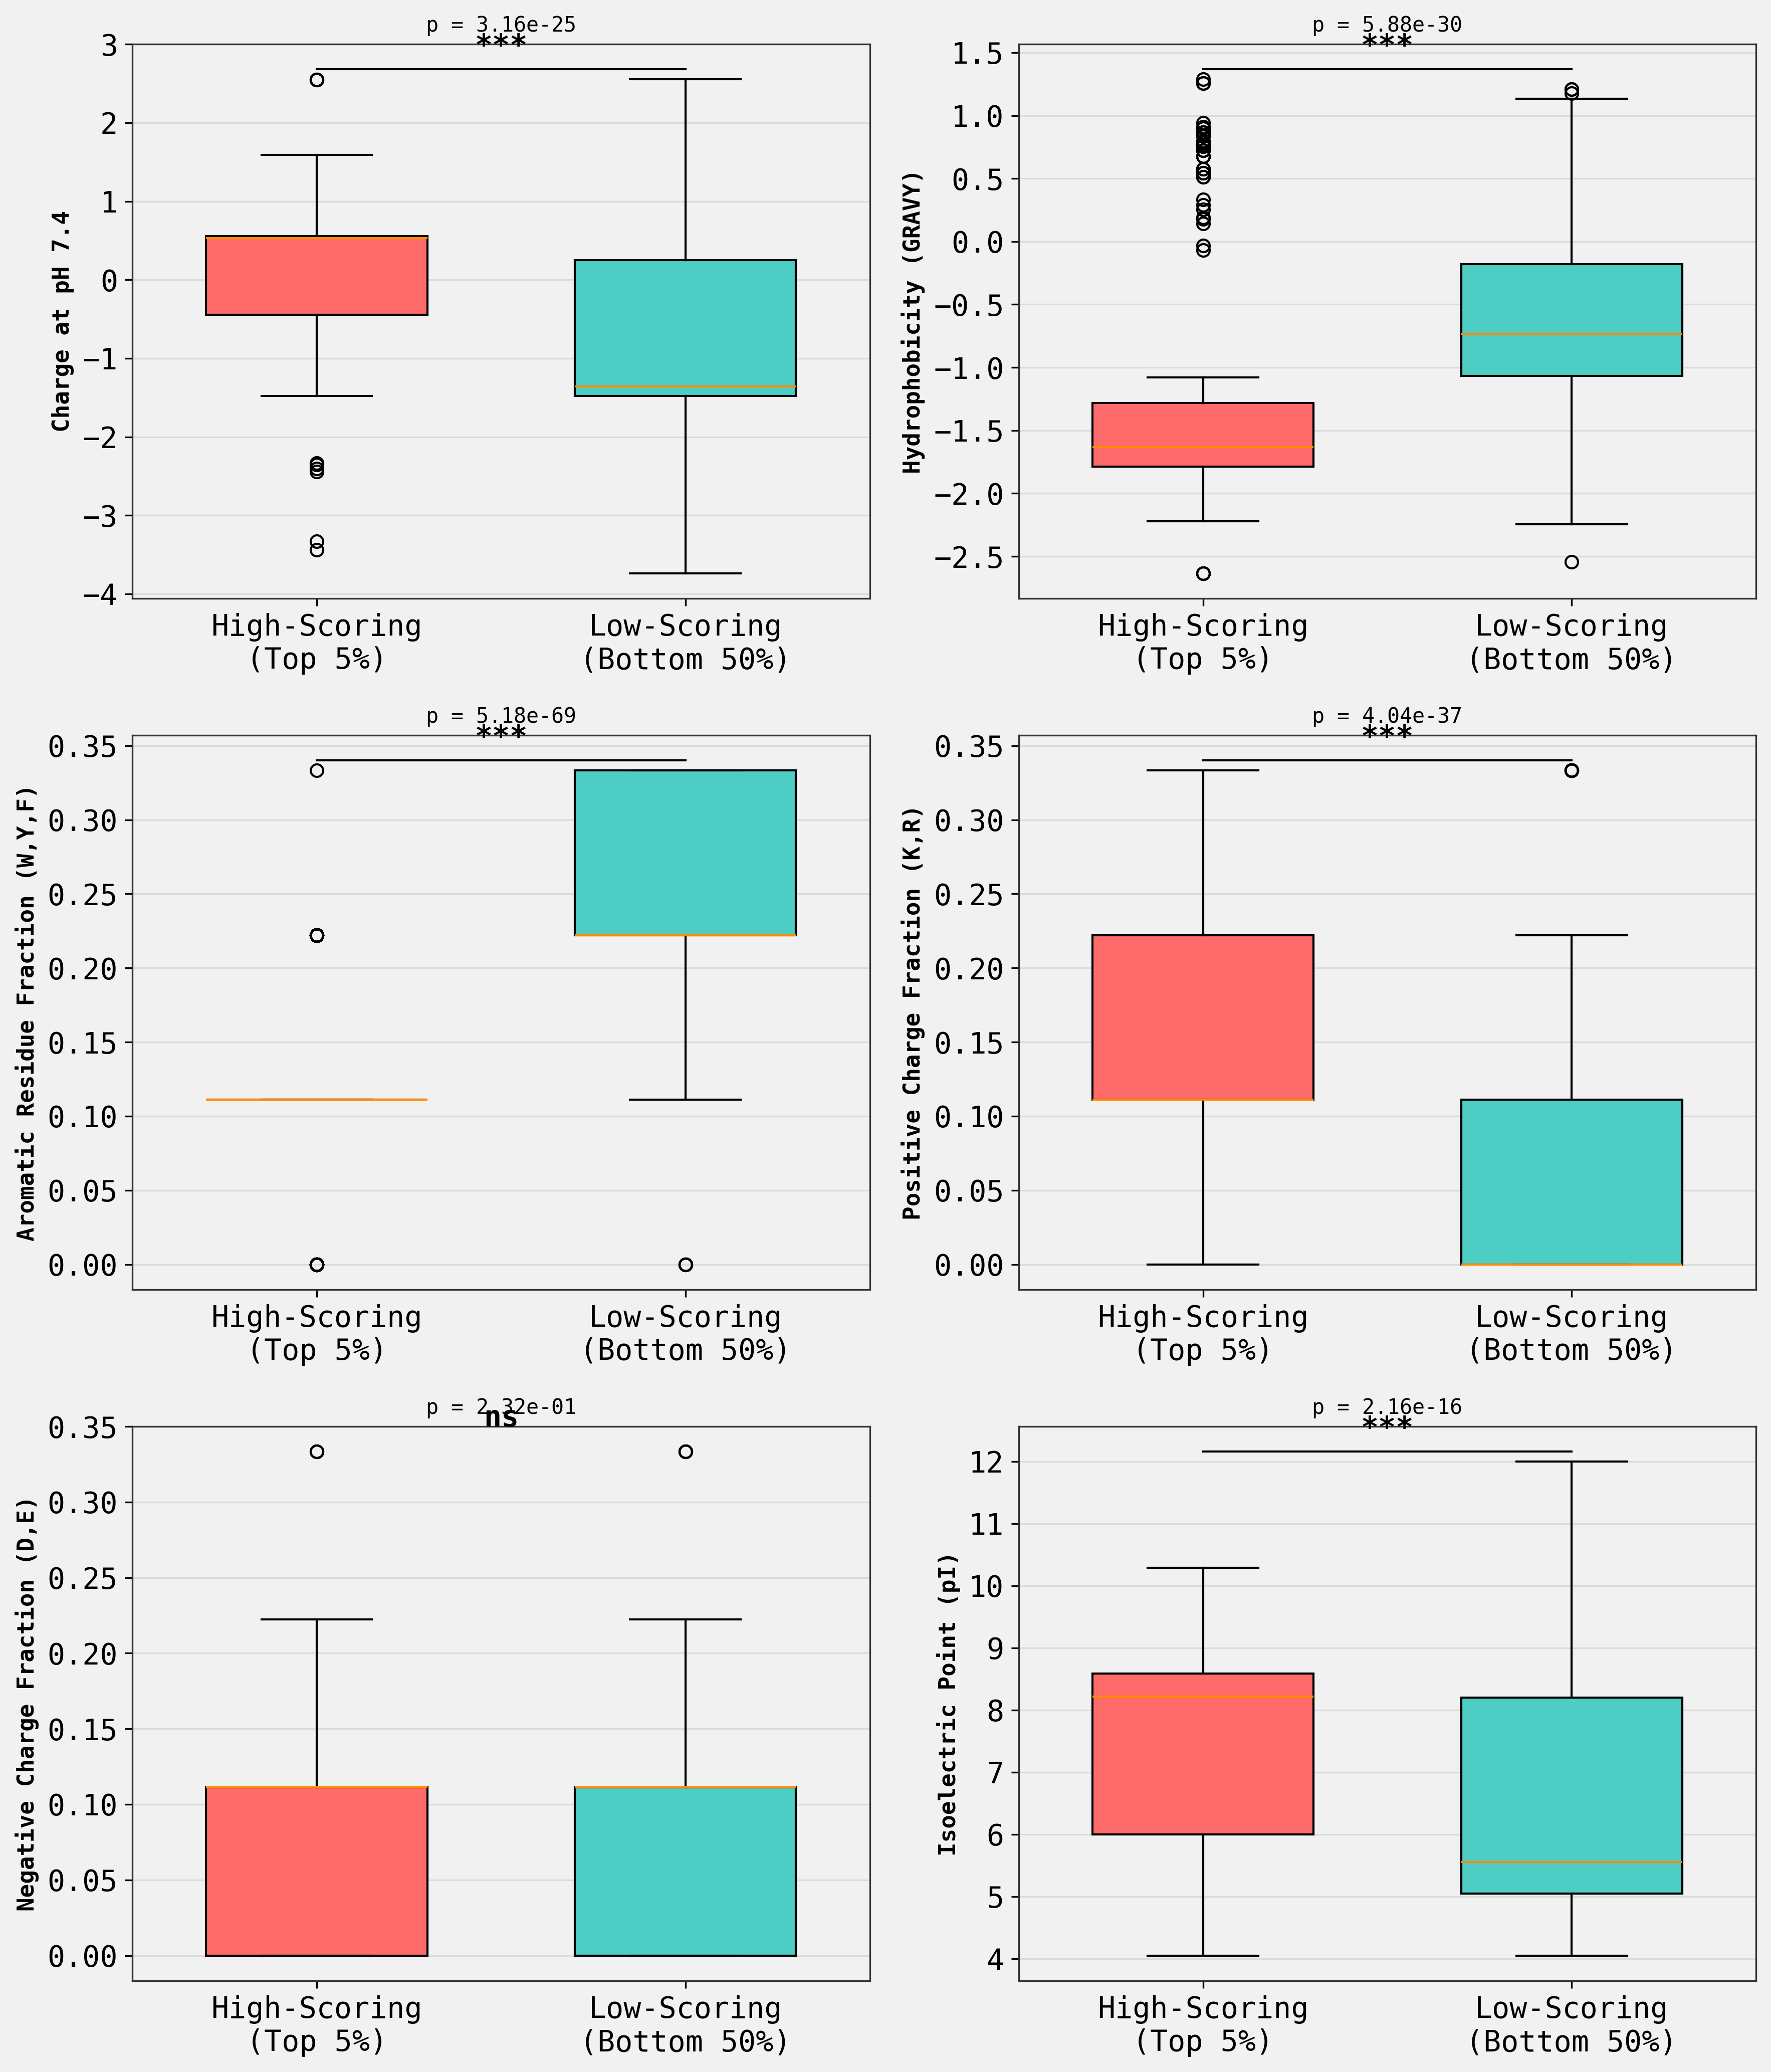

In [ ]:

# Step 7: Create visualizations to show the significant differences
# We'll create box plots for each physicochemical property

fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.flatten()

properties = ['charge_pH7.4', 'hydrophobicity', 'aromatic_fraction', 
              'positive_fraction', 'negative_fraction', 'pI']

property_labels = {
    'charge_pH7.4': 'Charge at pH 7.4',
    'hydrophobicity': 'Hydrophobicity (GRAVY)',
    'aromatic_fraction': 'Aromatic Residue Fraction (W,Y,F)',
    'positive_fraction': 'Positive Charge Fraction (K,R)',
    'negative_fraction': 'Negative Charge Fraction (D,E)',
    'pI': 'Isoelectric Point (pI)'
}

for idx, prop in enumerate(properties):
    ax = axes[idx]
    
    # Get data for both groups
    high_data = high_props_df[prop].values
    low_data = low_props_df[prop].values
    
    # Create box plots
    bp = ax.boxplot([high_data, low_data], labels=['High-Scoring\n(Top 5%)', 'Low-Scoring\n(Bottom 50%)'],
                     patch_artist=True, widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('#FF6B6B')
    bp['boxes'][1].set_facecolor('#4ECDC4')
    
    # Add significance stars
    result = results_df[results_df['Property'] == prop].iloc[0]
    if result['P_Value'] < 0.001:
        sig_label = '***'
    elif result['P_Value'] < 0.01:
        sig_label = '**'
    elif result['P_Value'] < 0.05:
        sig_label = '*'
    else:
        sig_label = 'ns'
    
    # Add significance annotation
    y_max = max(high_data.max(), low_data.max())
    y_min = min(high_data.min(), low_data.min())
    y_range = y_max - y_min
    ax.text(1.5, y_max + 0.05 * y_range, sig_label, ha='center', fontsize=14, fontweight='bold')
    
    # Add horizontal line for significance
    if sig_label != 'ns':
        ax.plot([1, 2], [y_max + 0.02 * y_range, y_max + 0.02 * y_range], 'k-', linewidth=1)
    
    ax.set_ylabel(property_labels[prop], fontsize=11, fontweight='bold')
    ax.set_title(f'p = {result["P_Value"]:.2e}', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('physicochemical_comparison.png', dpi=300, bbox_inches='tight')
print("Box plot comparison saved as 'physicochemical_comparison.png'")
plt.show()


In [ ]:

# Step 8: Additional analysis - Check for specific patterns or amino acid preferences
# Let's look at the amino acid composition in more detail

from collections import Counter

def get_aa_composition(sequences):
    """Get amino acid composition across multiple sequences"""
    all_aas = ''.join(sequences)
    aa_counts = Counter(all_aas)
    total = len(all_aas)
    aa_freq = {aa: count/total for aa, count in aa_counts.items()}
    return aa_freq

# Get amino acid compositions
high_aa_freq = get_aa_composition(high_props_df['Motif'].values)
low_aa_freq = get_aa_composition(low_props_df['Motif'].values)

# Calculate enrichment (fold change)
all_aas = sorted(set(list(high_aa_freq.keys()) + list(low_aa_freq.keys())))
enrichment_data = []
for aa in all_aas:
    high_freq = high_aa_freq.get(aa, 0)
    low_freq = low_aa_freq.get(aa, 0)
    # Add pseudocount to avoid division by zero
    fold_change = (high_freq + 0.001) / (low_freq + 0.001)
    enrichment_data.append({
        'AA': aa,
        'High_Freq': high_freq,
        'Low_Freq': low_freq,
        'Fold_Change': fold_change
    })

enrichment_df = pd.DataFrame(enrichment_data)
enrichment_df = enrichment_df.sort_values('Fold_Change', ascending=False)

print("Amino Acid Enrichment Analysis (High-Scoring vs. Low-Scoring)")
print("="*80)
print("\nTop 10 amino acids enriched in HIGH-scoring motifs:")
print(enrichment_df.head(10).to_string(index=False))
print("\nTop 10 amino acids enriched in LOW-scoring motifs:")
print(enrichment_df.tail(10).to_string(index=False))


Amino Acid Enrichment Analysis (High-Scoring vs. Low-Scoring)

Top 10 amino acids enriched in HIGH-scoring motifs:
AA  High_Freq  Low_Freq  Fold_Change
 T   0.128205  0.010915    10.844007
 P   0.084860  0.022136     3.711022
 K   0.119048  0.053593     2.198943
 R   0.039072  0.018151     2.092469
 V   0.089744  0.048013     1.851410
 E   0.080586  0.049975     1.600497
 Y   0.104396  0.070885     1.466160
 Q   0.112943  0.109149     1.034442
 C   0.026252  0.026674     0.984733
 S   0.086081  0.090385     0.952897

Top 10 amino acids enriched in LOW-scoring motifs:
AA  High_Freq  Low_Freq  Fold_Change
 I   0.036630  0.046909     0.785440
 L   0.011600  0.015085     0.783327
 A   0.008547  0.013920     0.639899
 H   0.018315  0.050343     0.376193
 N   0.014652  0.051386     0.298783
 D   0.013431  0.048626     0.290793
 M   0.012210  0.059848     0.217099
 W   0.004884  0.049362     0.116834
 F   0.007326  0.115894     0.071227
 G   0.001221  0.048749     0.044644


In [ ]:

# Let's perform a Fisher's exact test for specific amino acid enrichments
# to test if specific amino acids are significantly enriched in high vs low-scoring motifs

from scipy.stats import fisher_exact

# For each amino acid, create a 2x2 contingency table and test
aa_enrichment_stats = []

for aa in all_aas:
    # Count occurrences in high-scoring motifs
    high_with_aa = sum(aa in motif for motif in high_props_df['Motif'])
    high_without_aa = len(high_props_df) - high_with_aa
    
    # Count occurrences in low-scoring motifs
    low_with_aa = sum(aa in motif for motif in low_props_df['Motif'])
    low_without_aa = len(low_props_df) - low_with_aa
    
    # Create contingency table
    contingency_table = [[high_with_aa, high_without_aa],
                        [low_with_aa, low_without_aa]]
    
    # Perform Fisher's exact test
    odds_ratio, pvalue = fisher_exact(contingency_table)
    
    # Calculate the fraction of motifs containing this AA
    high_fraction = high_with_aa / len(high_props_df)
    low_fraction = low_with_aa / len(low_props_df)
    
    aa_enrichment_stats.append({
        'AA': aa,
        'High_Fraction': high_fraction,
        'Low_Fraction': low_fraction,
        'Odds_Ratio': odds_ratio,
        'P_Value': pvalue,
        'Significant': 'Yes' if pvalue < 0.05 else 'No'
    })

aa_stats_df = pd.DataFrame(aa_enrichment_stats)
aa_stats_df = aa_stats_df.sort_values('Odds_Ratio', ascending=False)

print("\nAmino Acid Presence/Absence Analysis (Fisher's Exact Test)")
print("="*80)
print("\nAmino acids significantly enriched in HIGH-scoring motifs (OR > 1, p < 0.05):")
high_enriched = aa_stats_df[(aa_stats_df['Odds_Ratio'] > 1) & (aa_stats_df['P_Value'] < 0.05)]
print(high_enriched.to_string(index=False))

print("\n\nAmino acids significantly enriched in LOW-scoring motifs (OR < 1, p < 0.05):")
low_enriched = aa_stats_df[(aa_stats_df['Odds_Ratio'] < 1) & (aa_stats_df['P_Value'] < 0.05)]
print(low_enriched.to_string(index=False))



Amino Acid Presence/Absence Analysis (Fisher's Exact Test)

Amino acids significantly enriched in HIGH-scoring motifs (OR > 1, p < 0.05):
AA  High_Fraction  Low_Fraction  Odds_Ratio      P_Value Significant
 T       0.796703      0.096578   36.658687 2.085482e-93         Yes
 P       0.730769      0.190397   11.541615 1.249993e-49         Yes
 V       0.752747      0.404525    4.481522 1.241064e-19         Yes
 K       0.747253      0.408940    4.273191 1.391828e-18         Yes
 Y       0.818681      0.565121    3.474550 4.910967e-12         Yes
 R       0.346154      0.155077    2.884446 2.053363e-09         Yes
 E       0.560440      0.395695    1.947176 2.486226e-05         Yes
 Q       0.692308      0.548565    1.851610 2.147213e-04         Yes


Amino acids significantly enriched in LOW-scoring motifs (OR < 1, p < 0.05):
AA  High_Fraction  Low_Fraction  Odds_Ratio      P_Value Significant
 I       0.247253      0.381347    0.532868 2.784926e-04         Yes
 H       0.153846      

Final figure saved as 'allosteric_motif_analysis_final.png'


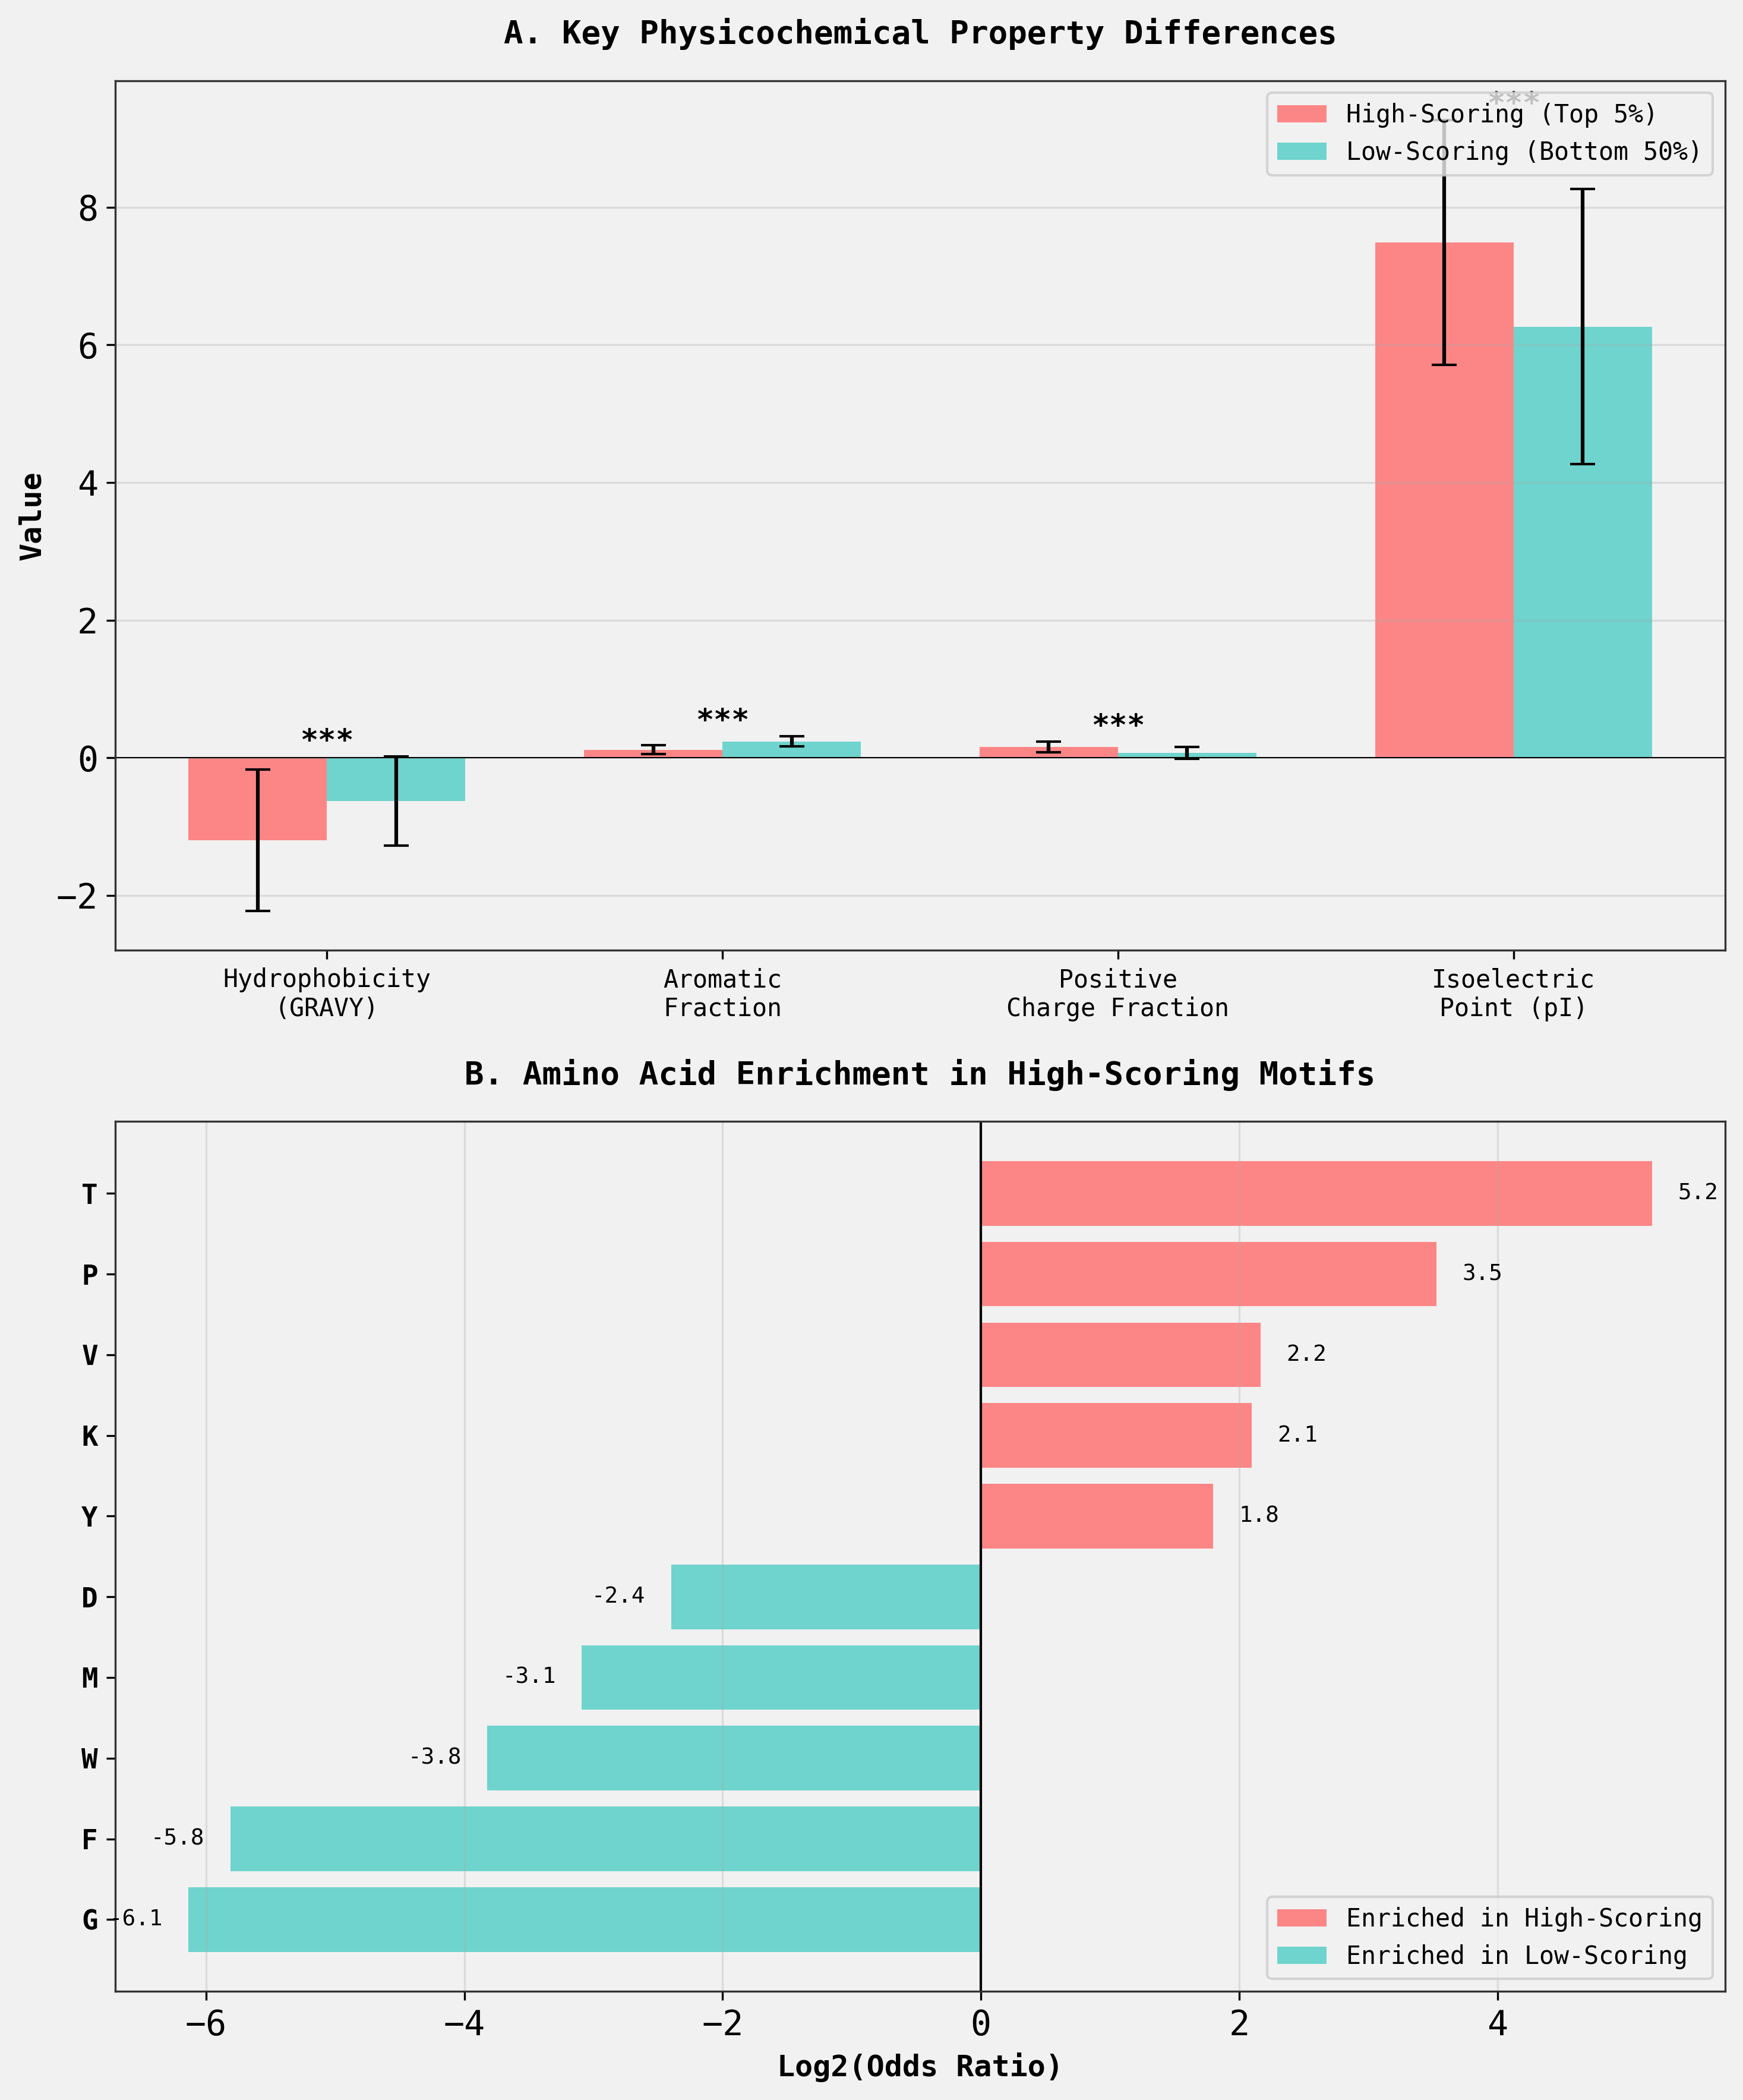

In [ ]:

# Step 9: Create a comprehensive summary and final visualization
# Let's create a single final figure showing the most important findings

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Panel A: Key physicochemical properties
properties_to_plot = ['hydrophobicity', 'aromatic_fraction', 'positive_fraction', 'pI']
property_labels_short = {
    'hydrophobicity': 'Hydrophobicity\n(GRAVY)',
    'aromatic_fraction': 'Aromatic\nFraction',
    'positive_fraction': 'Positive\nCharge Fraction',
    'pI': 'Isoelectric\nPoint (pI)'
}

x_pos = np.arange(len(properties_to_plot))
high_means = [results_df[results_df['Property'] == p]['High_Mean'].values[0] for p in properties_to_plot]
low_means = [results_df[results_df['Property'] == p]['Low_Mean'].values[0] for p in properties_to_plot]
high_stds = [results_df[results_df['Property'] == p]['High_Std'].values[0] for p in properties_to_plot]
low_stds = [results_df[results_df['Property'] == p]['Low_Std'].values[0] for p in properties_to_plot]

width = 0.35
ax1.bar(x_pos - width/2, high_means, width, label='High-Scoring (Top 5%)', 
        color='#FF6B6B', yerr=high_stds, capsize=5, alpha=0.8)
ax1.bar(x_pos + width/2, low_means, width, label='Low-Scoring (Bottom 50%)', 
        color='#4ECDC4', yerr=low_stds, capsize=5, alpha=0.8)

ax1.set_ylabel('Value', fontsize=12, fontweight='bold')
ax1.set_title('A. Key Physicochemical Property Differences', fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([property_labels_short[p] for p in properties_to_plot], fontsize=10)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add significance stars
for i, prop in enumerate(properties_to_plot):
    result = results_df[results_df['Property'] == prop].iloc[0]
    if result['P_Value'] < 0.001:
        sig_label = '***'
    elif result['P_Value'] < 0.01:
        sig_label = '**'
    else:
        sig_label = '*'
    y_max = max(high_means[i] + high_stds[i], low_means[i] + low_stds[i])
    ax1.text(i, y_max + 0.1, sig_label, ha='center', fontsize=12, fontweight='bold')

# Panel B: Amino acid enrichment
# Show the most significantly enriched/depleted amino acids
sig_enriched = aa_stats_df[aa_stats_df['P_Value'] < 0.001].copy()
sig_enriched['Log2_OR'] = np.log2(sig_enriched['Odds_Ratio'])
sig_enriched = sig_enriched.sort_values('Log2_OR', ascending=True)

# Select top enriched and depleted
top_depleted = sig_enriched.head(5)
top_enriched = sig_enriched.tail(5)
aa_to_plot = pd.concat([top_depleted, top_enriched])

colors = ['#4ECDC4' if x < 0 else '#FF6B6B' for x in aa_to_plot['Log2_OR']]
y_pos = np.arange(len(aa_to_plot))

ax2.barh(y_pos, aa_to_plot['Log2_OR'], color=colors, alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(aa_to_plot['AA'], fontsize=11, fontweight='bold')
ax2.set_xlabel('Log2(Odds Ratio)', fontsize=12, fontweight='bold')
ax2.set_title('B. Amino Acid Enrichment in High-Scoring Motifs', fontsize=13, fontweight='bold', pad=15)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

# Add text labels
for i, (idx, row) in enumerate(aa_to_plot.iterrows()):
    x_pos = row['Log2_OR']
    if x_pos < 0:
        ax2.text(x_pos - 0.2, i, f"{row['Log2_OR']:.1f}", va='center', ha='right', fontsize=9)
    else:
        ax2.text(x_pos + 0.2, i, f"{row['Log2_OR']:.1f}", va='center', ha='left', fontsize=9)

# Add legend for direction
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.8, label='Enriched in High-Scoring'),
                   Patch(facecolor='#4ECDC4', alpha=0.8, label='Enriched in Low-Scoring')]
ax2.legend(handles=legend_elements, fontsize=10, loc='lower right')

plt.tight_layout()
plt.savefig('allosteric_motif_analysis_final.png', dpi=300, bbox_inches='tight')
print("Final figure saved as 'allosteric_motif_analysis_final.png'")
plt.show()


In [ ]:

# Step 10: Generate comprehensive summary report with key findings

print("="*80)
print("COMPREHENSIVE SUMMARY REPORT")
print("Physicochemical Analysis of High-Scoring vs. Low-Scoring Allosteric 9-mer Motifs")
print("="*80)

print("\n1. DATASET OVERVIEW:")
print(f"   - Total unique allosteric 9-mer motifs analyzed: {len(motif_scores)}")
print(f"   - High-scoring group (top 5%): {len(high_scoring)} motifs")
print(f"   - Low-scoring group (bottom 50%): {len(low_scoring)} motifs")
print(f"   - Z-score range for high-scoring: {high_scoring['Avg_Z_Score'].min():.3f} to {high_scoring['Avg_Z_Score'].max():.3f}")
print(f"   - Z-score range for low-scoring: {low_scoring['Avg_Z_Score'].min():.3f} to {low_scoring['Avg_Z_Score'].max():.3f}")

print("\n2. KEY PHYSICOCHEMICAL PROPERTIES (Mann-Whitney U test):")
print("\n   SIGNIFICANT DIFFERENCES (p < 0.001):")
for _, row in results_df.iterrows():
    if row['P_Value'] < 0.001:
        direction = "HIGHER" if row['High_Mean'] > row['Low_Mean'] else "LOWER"
        print(f"   - {row['Property']}: High-scoring motifs have {direction} values")
        print(f"     High: {row['High_Mean']:.4f} ± {row['High_Std']:.4f}")
        print(f"     Low:  {row['Low_Mean']:.4f} ± {row['Low_Std']:.4f}")
        print(f"     Diff: {abs(row['High_Mean'] - row['Low_Mean']):.4f}, p = {row['P_Value']:.2e}, effect size = {row['Effect_Size']:.3f}")

print("\n   NON-SIGNIFICANT PROPERTIES (p >= 0.05):")
for _, row in results_df.iterrows():
    if row['P_Value'] >= 0.05:
        print(f"   - {row['Property']}: p = {row['P_Value']:.3f} (no significant difference)")

print("\n3. AMINO ACID COMPOSITION ANALYSIS (Fisher's Exact Test):")
print("\n   HIGHLY ENRICHED in HIGH-scoring motifs (p < 0.001, OR > 2):")
for _, row in aa_stats_df.iterrows():
    if row['P_Value'] < 0.001 and row['Odds_Ratio'] > 2:
        print(f"   - {row['AA']}: OR = {row['Odds_Ratio']:.2f}, p = {row['P_Value']:.2e}")
        print(f"     Frequency: {row['High_Fraction']:.2%} (high) vs {row['Low_Fraction']:.2%} (low)")

print("\n   HIGHLY DEPLETED in HIGH-scoring motifs (p < 0.001, OR < 0.5):")
for _, row in aa_stats_df.iterrows():
    if row['P_Value'] < 0.001 and row['Odds_Ratio'] < 0.5:
        print(f"   - {row['AA']}: OR = {row['Odds_Ratio']:.2f}, p = {row['P_Value']:.2e}")
        print(f"     Frequency: {row['High_Fraction']:.2%} (high) vs {row['Low_Fraction']:.2%} (low)")

print("\n" + "="*80)


COMPREHENSIVE SUMMARY REPORT
Physicochemical Analysis of High-Scoring vs. Low-Scoring Allosteric 9-mer Motifs

1. DATASET OVERVIEW:
   - Total unique allosteric 9-mer motifs analyzed: 3625
   - High-scoring group (top 5%): 182 motifs
   - Low-scoring group (bottom 50%): 1812 motifs
   - Z-score range for high-scoring: 1.597 to 2.993
   - Z-score range for low-scoring: -2.789 to 0.072

2. KEY PHYSICOCHEMICAL PROPERTIES (Mann-Whitney U test):

   SIGNIFICANT DIFFERENCES (p < 0.001):
   - charge_pH7.4: High-scoring motifs have HIGHER values
     High: 0.1378 ± 1.0820
     Low:  -0.7832 ± 1.1721
     Diff: 0.9210, p = 3.16e-25, effect size = -0.466
   - hydrophobicity: High-scoring motifs have LOWER values
     High: -1.1988 ± 1.0247
     Low:  -0.6302 ± 0.6460
     Diff: 0.5686, p = 5.88e-30, effect size = 0.511
   - aromatic_fraction: High-scoring motifs have LOWER values
     High: 0.1166 ± 0.0651
     Low:  0.2361 ± 0.0739
     Diff: 0.1195, p = 5.18e-69, effect size = 0.722
   - posit